# Apresentação:

    A proposta aqui é começar a estudar um pouco sobre RAG, Retrieval
    Augmented Generation, uma forma interessante de se construir um LLM,
    Large Language Model, mais preciso em suas respostas.

**Instalação do SGBD orientado a vetor**

    A ideia do RAG é basicamente validar a resposta
    construida pelo LLM com informações de confiança.
    Essas informação precisam estar armazenadas, a forma
    de se fazer isso de modo eficiente na computação é por
    meio de SGBDs.

In [1]:
!pip install vectordb2
!pip install langchain

**O motor do nosso RAG**

    Dissemos acima que o RAG precisa ter informações de
    confiança armazenada, mas como o modelo sabe que a
    informação de confiança tem a ver com o prompt do
    usuário?

    Para esse projeto, a forma que vamos utilizar aqui
    para checar a similiaridade do assunto proposto no
    prompt com a infomações de confiança é por distância.
    O algorítmo mais comum que classifica informação por
    meio de distância é o KNN. Ou seja, vamos usar o
    KNN para escolher a informação de confiança que valide
    a resposta do modelo, ou seja, que contextualize a
    resposta do modelo ao prompt.

In [2]:
# MRPT - fast nearest neighbor search with random projection
!pip install git+http://github.com/vioshyvo/mrpt/

  Cloning http://github.com/vioshyvo/mrpt/ to /tmp/pip-req-build-ujvbx_li
  Running command git clone --filter=blob:none --quiet http://github.com/vioshyvo/mrpt/ /tmp/pip-req-build-ujvbx_li
  Resolved http://github.com/vioshyvo/mrpt/ to commit 88cc6f40782ca0f8de7491279766ded01d767861
  Preparing metadata (setup.py) ... done


**Nota**

    Precisamos que todo esse processo de validação da resposta
    seja rápido, o que pode não acontecer, dado a quantidade
    massiva de dados para se processar, por isso da instalação
    desse projeto do github que otimiza o KNN. É construido em C++
    o que auxilia na velocidade de busca.

# Retrieval Augmented Generation(RAG):

    RAG, Retrieval Augmented Generation, é uma forma de se construir
    um LLM, Large Language Model, mais preciso na sua resposta. A ideia
    é construir um pipeline que combina a capacidade de recuperar informações
    relevantes com a habilidade de gerar novos conteúdos de maneira aprimorada.
    Esse tipo de abordagem é comumente utilizado em modelos que buscam melhorar
    a qualidade e relevância da geração de texto, incorporando informações
    pré-existentes através de mecanismos de recuperação.

## Importando o documento:

**Documento Base**

    O Documento base é a nossa informação de confiança, o "manual" por
    assim dizer, que a IA ira checar para validar suas repostas. Aqui
    vamos trabalhar com um projeto muito legal que estruturou a
    constituição federal.


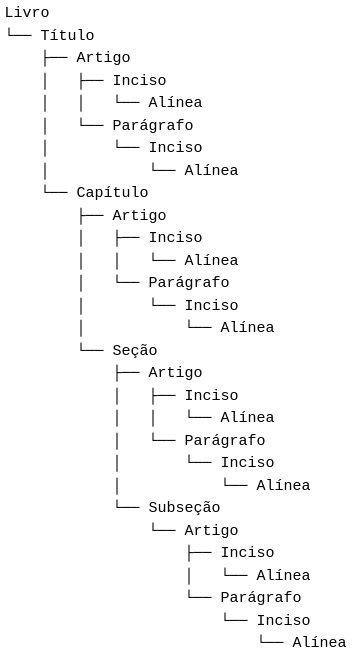

    Os dados estando estruturados facilitam o funcionamento do
    modelo, mas também acredito, pensando um pouco nessa onda de
    concursos públicos, o concurso público unificado que terá,
    acredito que possa ser uma proposta bem interessante.


In [3]:
import re
import requests

In [ ]:
# Importando o Texto bruto:
bruto_text = requests.get('https://raw.githubusercontent.com/abjur/constituicao/main/CONSTITUICAO.md').text
bruto_text

**Regex - Regular Expression**

    A ideia aqui é usaro Regex ajustar o texto bruto baixado. Entender
    de Regex é interessante, aqui não é o lugar apropriado para abordar
    o tema e honestamente eu não tenho competência para explicar sobre,
    mas fica ai a recomendação para o leitor (Inclusive eu mesmo hahaha),
    dar uma olhada sobre.

In [5]:
# Otimização do Texto:
padrao_capitulo = r'^##\s+(.*)$' # A ideia é pegar tudo que vem depois do ##
sections = re.split(padrao_capitulo, bruto_text, flags=re.MULTILINE)
sections = [section.strip() for section in sections[1:]]

In [6]:
# Analisando a organização do texto:
sections[:2]

['Título I: Dos Princípios Fundamentais',
 '**Art. 1º** A República Federativa do Brasil, formada pela união indissolúvel dos Estados e Municípios e do Distrito Federal, constitui-se em Estado democrático de direito e tem como fundamentos:\n\n\u2003\u2003I - a soberania;\n\n\u2003\u2003II - a cidadania;\n\n\u2003\u2003III - a dignidade da pessoa humana;\n\n\u2003\u2003IV - os valores sociais do trabalho e da livre iniciativa;\n\n\u2003\u2003V - o pluralismo político.\n\n\u2003**Parágrafo único.** Todo o poder emana do povo, que o exerce por meio de representantes eleitos ou diretamente, nos termos desta Constituição.\n\n**Art. 2º** São Poderes da União, independentes e harmônicos entre si, o Legislativo, o Executivo e o Judiciário.\n\n**Art. 3º** Constituem objetivos fundamentais da República Federativa do Brasil:\n\n\u2003\u2003I - construir uma sociedade livre, justa e solidária;\n\n\u2003\u2003II - garantir o desenvolvimento nacional;\n\n\u2003\u2003III - erradicar a pobreza e a mar

    Olha a diferança do texto bruto para o texto organizado
    com a regex... Se faz interessante esse tratamento de string
    porque a partir de agora queremos começar a estruturar os nossos
    dados para o modelo.

In [7]:
from langchain.text_splitter import MarkdownHeaderTextSplitter

    um arquivo Markdown é organizado por cabeçalhos. Criar "chunks"
    dentro de grupos específicos de cabeçalhos é uma ideia intuitiva.
    Para lidar com esse desafio, podemos usar o MarkdownHeaderTextSplitter.
    Isso irá dividir um arquivo Markdown por um conjunto especificado de
    cabeçalhos.

In [8]:
# Definição inicio do capitulo:
padrao_capitulo = [("##","Capitulo")]

# Marcando:
markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=padrao_capitulo)
sections = markdown_splitter.split_text(bruto_text)

In [9]:
sections[:2]

[Document(page_content='# Constituição da República Federativa do Brasil  \n**Preâmbulo**  \nNós, representantes do povo brasileiro, reunidos em Assembléia Nacional Constituinte para instituir um Estado Democrático, destinado a assegurar o exercício dos direitos sociais e individuais, a liberdade, a segurança, o bem-estar, o desenvolvimento, a igualdade e a justiça como valores supremos de uma sociedade fraterna, pluralista e sem preconceitos, fundada na harmonia social e comprometida, na ordem interna e internacional, com a solução pacífica das controvérsias, promulgamos, sob a proteção de Deus, a seguinte CONSTITUIÇÃO DA REPÚBLICA FEDERATIVA DO BRASIL.'),
 Document(page_content='**Art. 1º** A República Federativa do Brasil, formada pela união indissolúvel dos Estados e Municípios e do Distrito Federal, constitui-se em Estado democrático de direito e tem como fundamentos:  \nI - a soberania;  \nII - a cidadania;  \nIII - a dignidade da pessoa humana;  \nIV - os valores sociais do trab

    Note que a estruturação dos dados mudou! Agora temos um page_content e
    um metadata. Esse metadata é fundamental para o RAG! Note que tudo que
    estamos fazendo é labelando o texto, de modo que o modelo consiga
    achar onde encontrar a informação de forma fácil.

## Embeddings:

    Embeddings nada mais é do que um processo de codificação comumente
    usados para representar palavras, frases ou outros tipos de dados
    textuais como números.

    Essa codificação é fundamental para o funcionamento do RAG, dado
    que precisamos calcular de alguma forma a similaridade entre o
    prompt do usuário e o texto base, para validar a resposta do modelo.


In [10]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [11]:
# Testando o Chunk size e Chunk Overlap:
chunk_size=20
chunk_overlap=3 # Janela Deslizante

**Chunk Size (Tamanho do Bloco):**

    Refere-se ao tamanho de cada bloco ou pedaço em que um conjunto de
    dados é dividido durante processamento ou análise. Em diversas áreas,
    como processamento de linguagem natural ou análise de sinais, por exemplo,
    é comum dividir sequências de dados em partes menores para facilitar o
    processamento. O "chunk size" é a medida desse tamanho de bloco.

**Chunk Overlap (Sobreposição de Bloco):**

    Representa a quantidade de sobreposição entre blocos consecutivos
    ao dividir um conjunto de dados em pedaços. Em alguns casos, pode ser
    benéfico permitir uma sobreposição entre blocos para garantir uma transição
    suave de informações entre eles. A "chunk overlap" indica a porcentagem ou
    quantidade de dados que se sobrepõem entre um bloco e o próximo.


In [12]:
text = "A República Federativa do Brasil, formada pela união indissolúvel dos Estados e Municípios e do Distrito Federal" # trecho do art. 1º

splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size,chunk_overlap=chunk_overlap)

    A ideia do Recursive pegar caractere por
    caractere recursivamente, de modo a dividir
    o modo dataset.

In [13]:
chunks = splitter.split_text(text)

for chunk in chunks:
  print(chunk)

A República
Federativa do
do Brasil, formada
pela união
indissolúvel dos
Estados e
e Municípios e do
do Distrito Federal


Nota:

    Se mudar o valor do chunk, ele não divide de maneira diferente,
    até o momento, eu ainda não sei definir qual é a forma optimal
    porém, esse me parece a melhor configuração do chunk.

**Indexando os dados no VectorDB**

    Precisamos armezenar os nossos de dados de alguma forma de modo
    que consigamos recupera-los quando for preciso, já comentamos que
    a melhor forma de se fazer isso é usando de um SGBD.

In [14]:
from vectordb import Memory

In [15]:
memory = Memory(chunking_strategy={'mode':'sliding_window',
                                   'window_size':128, # Chunk_size
                                   'overlap':8 # Chunk Overlap / Janela Deslizante
                                   })

Initiliazing embeddings:  normal


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


OK.


In [18]:
from tqdm import tqdm

In [19]:
for i in tqdm(range(0,len(sections))):
  capitulo = sections[i].metadata
  texto = sections[i].page_content

  metadata = {'capitulo':capitulo,
              'origem':'Constituição Federal'}

  memory.save(texto,metadata)

100%|██████████| 11/11 [05:47<00:00, 31.59s/it]


    Note que precisamos tanto do conteudo da página
    quanto do metadata. É nesse ponto que o langchain
    nos ajuda. Se fossemos tratar essa string na mão,
    seria um trabalho bem arduo.

In [21]:
# Pesquisa:
memory.search('direitos dos trabalhadores', top_n=5)

[{'chunk': 'direitos sociais a educação, a saúde, a alimentação, o trabalho, a moradia, o transporte, o lazer, a segurança, a previdência social, a proteção à maternidade e à infância, a assistência aos desamparados, na forma desta Constituição. **Art. 7º** São direitos dos trabalhadores urbanos e rurais, além de outros que visem à melhoria de sua condição social: I - relação de emprego protegida contra despedida arbitrária ou sem justa causa, nos termos de lei complementar, que preverá indenização compensatória, dentre outros direitos; II - seguro-desemprego, em caso de desemprego involuntário; III - fundo de garantia do tempo de serviço; IV - salário mínimo, fixado em lei, nacionalmente unificado, capaz de atender às suas necessidades vitais básicas e às de sua família com moradia, alimentação, educação, saúde, lazer, vestuário, higiene,',
  'metadata': {'capitulo': {'Capitulo': 'Título II: Dos Direitos e Garantias Fundamentais'},
   'origem': 'Constituição Federal'},
  'distance': 0